In [1]:
#pip install imageio

In [1]:
##This is a framework of patch-based hyperspectral classification
import os
import time
import random
import spectral
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.patches as mpts
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from sklearn.preprocessing import minmax_scale
from scipy.io import loadmat
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
##hypeperameters and experimental settings
RANDOM_SEED=666
MODEL_NAME = '3D2DConvKAN' ## your model name
DATASET = 'Tangdaowan'  ## PU  IP  SA or your personal dataset
TRAIN_RATE = 0.3  ## ratio of training data
VAL_RATE = 0.2    ## ratio of valuating data
EPOCH = 5    ##number of epoch
VAL_EPOCH = 1  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 64
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components   0:use origin data
NORM = True  ## normalization or not
PATCH_SIZE = 9 ## patchsize of input 3D cube   1:only spectral sequence
CHECK_POINT = None  ## path of check point model

SAVE_PATH = f"E:/Roy/Sim Pool/Results\\{MODEL_NAME}\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [3]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def loadData(name): ## customize data and return data label and class_name
    data_path = os.path.join(os.getcwd(),'E:/Roy/Sim Pool/Data/')
    if name == 'Tangdaowan':
        data = loadmat(os.path.join(data_path, 'QUH-Tangdaowan.mat'))['Tangdaowan']
        labels = loadmat(os.path.join(data_path, 'QUH-Tangdaowan_GT.mat'))['TangdaowanGT']
        class_name = [     "Rubber track",    "Flaggingv",    "Sandy",    "Asphalt",    "Boardwalk",    "Rocky shallows",    "Grassland",
    "Bulrush",    "Gravel road",    "Ligustrum vicaryi",    "Coniferous pine",    "Spiraea",    "Bare soil",    "Buxus sinica",    "Photinia serrulata",
    "Populus",    "Ulmus pumila L",    "Seawater"]
    
    elif name == 'Qingyun':
        data = loadmat(os.path.join(data_path, 'QUH-Qingyun.mat'))['Chengqu']
        labels = loadmat(os.path.join(data_path, 'QUH-Qingyun_GT.mat'))['ChengquGT']
        class_name = ["Trees", "Concrete building", "Car", "Ironhide building", "Plastic playground", "Asphalt road"]
    
    elif name == 'Pingan':
        data = loadmat(os.path.join(data_path, 'QUH-Pingan.mat'))['Haigang']
        labels = loadmat(os.path.join(data_path, 'QUH-Pingan_GT.mat'))['HaigangGT']
        class_name = ["Ship", "Seawater", "Trees"," Concrete structure building", "Floating pier", "Brick houses", 
                      "Steel houses"," Wharf construction land", "Car", "Road"]
    return data, labels, class_name


In [5]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

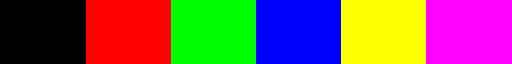

In [6]:
a = data[:,:,[1,2,3]]
cmap=plt.matplotlib.colors.ListedColormap(spectral.spy_colors/255,'Classification',6)
cmap

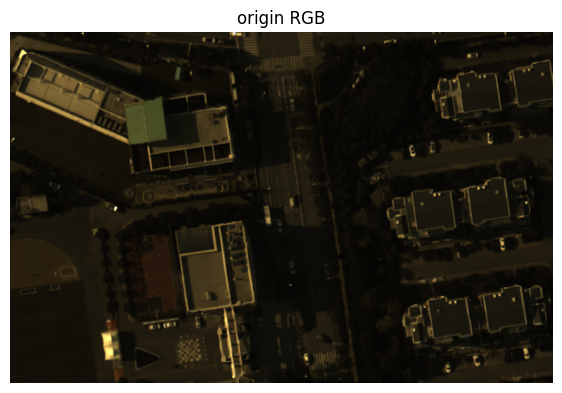

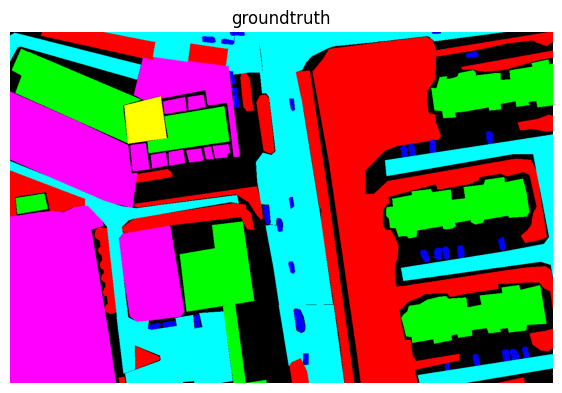

In [7]:
def img_display(data = None, rgb_band = None, classes = None,class_name = None,title = None, 
                figsize = (7,7),palette = spectral.spy_colors):
    if data is not None:
        im_rgb = np.zeros_like(data[:,:,0:3])
        im_rgb = data[:,:,rgb_band]
        im_rgb = im_rgb/(np.max(np.max(im_rgb,axis = 1),axis = 0))*255
        im_rgb = np.asarray(im_rgb,np.uint8)
        fig, rgbax = plt.subplots(figsize = figsize)
        rgbax.imshow(im_rgb)
        rgbax.set_title(title)
        rgbax.axis('off')
        
    elif classes is not None:
        rgb_class = np.zeros((classes.shape[0],classes.shape[1],3))
        for i in np.unique(classes):
            rgb_class[classes==i]=palette[i]
        rgb_class = np.asarray(rgb_class, np.uint8)
        _,classax = plt.subplots(figsize = figsize)
        classax.imshow(rgb_class)
        classax.set_title(title)
        classax.axis('off')
        # rect = [mpts.Rectangle((0,0),1,1,facecolor=palette[i]/255) for i in range(len(class_name))]
        # classax.legend(rect,class_name,bbox_to_anchor = (1.04,1),frameon=False,loc = 'upper left')
        
img_display(data,(30,20,10),title='origin RGB')
img_display(classes=label,title='groundtruth',class_name=class_name)

In [8]:
# ## display HSI
# rgb_view=spectral.imshow(data,(30,20,10),classes=label.astype(int),title='RGB origin',figsize=(7,7))
# gt_view = spectral.imshow(classes=label.astype(int), title='GroundTruth',figsize=(7,7))
# view = spectral.imshow(data,(30,20,10),classes=label.astype(int),figsize=(7,7))
# view.set_display_mode('overlay')
# view.set_title('Overlay')
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [9]:
def applyPCA(X, numComponents=15, norm = True):
    """PCA and processing
    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional):  number of reserved components(Defaults to 15, 0 for no PCA).
        norm: normalization or not
    Returns:
        newX: processed data
        pca: 
    """
    
    if numComponents == 0:
        newX = np.reshape(X, (-1, X.shape[2]))
    else:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents)   ##PCA and normalization
        newX = pca.fit_transform(newX)
    if norm:
        newX = minmax_scale(newX, axis=1)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], -1))
    return newX, newX.shape[2]

In [10]:
data,N_PCA = applyPCA(data, N_PCA, NORM)
data.shape,N_PCA

((880, 1360, 15), 15)

In [11]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [12]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

          class          train_num  val_num   test_num   total   
          Trees            83445     55630     139075    278150  
    Concrete building      53853     35902     89757     179512  
           Car              4135      2757      6891     13783   
    Ironhide building       2930      1953      4884      9767   
   Plastic playground      65320     43547     108868    217735  
      Asphalt road         76784     51189     127973    255946  
          total            286467    190978    477448    954893  


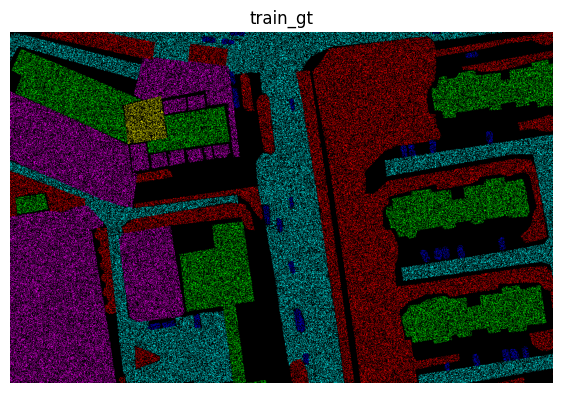

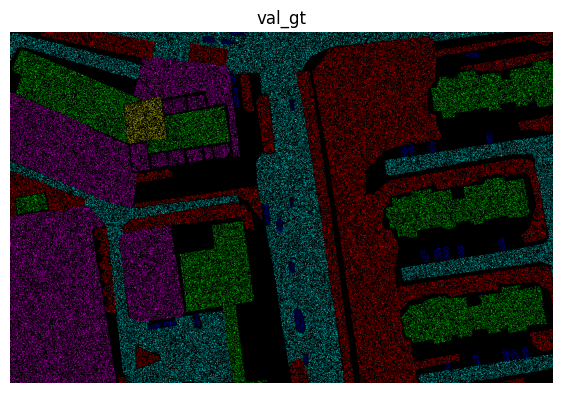

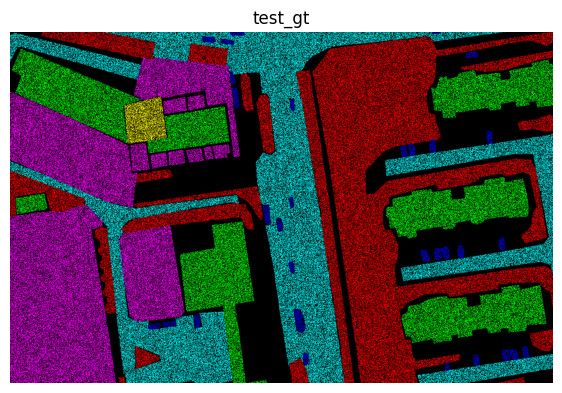

In [13]:
## display sampling info
sample_report = f"{'class': ^25}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{class_name[i-1]: ^25}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^25}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
img_display(classes=train_gt,title='train_gt')
img_display(classes=val_gt,title='val_gt')
img_display(classes=test_gt,title='test_gt')

# spectral.imshow(classes=train_gt, title='train_gt')
# spectral.imshow(classes=val_gt, title='val_gt')
# spectral.imshow(classes=test_gt, title='test_gt')

In [14]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        data = torch.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [15]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [16]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 8, 8, 1]), tensor(1))

In [17]:
#pip install unfoldNd

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from ConvKAN import ConvKAN
from ConvKAN3D import effConvKAN3D
from fast_kan import FastKAN as KAN

In [3]:
in_chs=15
patch_size=8


class Net(nn.Module):
    # Define the architecture of the network
    def __init__(self):
        super(Net, self).__init__()
        
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.ConvKAN1 = effConvKAN3D(in_channels=15, out_channels=8, kernel_size=1)
        self.ConvKAN2 = effConvKAN3D(in_channels=8, out_channels=16, kernel_size=1)
        self.ConvKAN3 = effConvKAN3D(in_channels=16, out_channels=32, kernel_size=1)
        
        self.ConvKAN4 = ConvKAN(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, version="Fast")
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        
        # 5*5 from image dimension
        #self.KAN1 =  KAN([4 * 4 * 4 , 64, 32])
        self.KAN1 = KAN([64, 32, NUM_CLASS])

    # Set the flow of data through the network for the forward pass
    # x represents the data
    def forward(self, x):
        # F.relu is the rectified-linear activation function
        
        x = self.ConvKAN1(x)
        x = self.ConvKAN2(x)
        x = self.ConvKAN3(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3]*x.shape[4])
        x = self.pool(self.ConvKAN4(x))

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, 1)
        x = self.KAN1(x)
        #x = self.KAN2(x)
        #x = self.KAN3(x)
        output = F.log_softmax(x, dim=1)
        
        return output

In [5]:
#instantiate CNN model
model = Net()
model

Net(
  (ConvKAN1): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN2): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN3): effConvKAN3D(
    (unfold): UnfoldNd()
    (linear): KANLinear(
      (base_activation): SiLU()
    )
  )
  (ConvKAN4): ConvKAN(
    (unfold): Unfold(kernel_size=3, dilation=1, padding=1, stride=2)
    (linear): Fast_KANLinear(
      (layernorm): LayerNorm((288,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=1440, out_features=64, bias=False)
      (base_activation): SiLU()
      (base_linear): Linear(in_features=288, out_features=64, bias=True)
    )
  )
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (KAN1): FastKAN(
    (layers): ModuleList(
      (0): Fast_KANLinear(
        (layernorm): LayerNorm((64,), eps=1e-05, e

In [6]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

In [22]:
#PATH = 'E:/Roy/Sim Pool/Results/Training/3D2DConvKAN_Tangdaowan_30.pth'
#model.load_state_dict(torch.load(PATH))
#moel=torch.load(PATH)

In [23]:
EPOCH=100


## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')

loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
epoch_start = 0

model = model ##modify to you model 
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)


if CHECK_POINT is not None:
    
    model_ckpt = torch.load(CHECK_POINT,map_location = device)
    model.load_state_dict(model_ckpt['state_dict'])
    epoch_start = model_ckpt['epoch']
    optimizer.load_state_dict(model_ckpt['optimizer'])
    loss_list = model_ckpt['loss_list']
    acc_list = model_ckpt['acc_list']
    val_acc_list = model_ckpt['val_acc_list']
    val_epoch_list = model_ckpt['val_epoch_list']

loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()
train_st = time.time()
run_error = False

try:
    for e in tqdm(range(epoch_start,EPOCH), desc="Training:"):
        
        model.train()
        avg_loss = 0.
        train_acc = 0
        
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            
            val_acc =0
            model.eval()
            
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            save_dict = {'state_dict':model.state_dict(), 'epoch':e+1, 'optimizer': optimizer.state_dict(),
                        'loss_list':loss_list, 'acc_list': acc_list, 'val_acc_list': val_acc_list, 'val_epoch_list':val_epoch_list}
            torch.save(save_dict,save_name)
except Exception as exc:
    print(exc)
    run_error = True
finally: 
    print(f'Stop in epoch {e}')
train_time = time.time()-train_st
print(f"training time: {train_time}")

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 0/100 loss:0.006832450529786403  acc:0.8515151832497286


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 0/100  val_acc:0.8865471415555718


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 1/100 loss:0.004860478321946391  acc:0.8946615142407328


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 1/100  val_acc:0.9040360669815372


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 2/100 loss:0.004195337329892593  acc:0.9090959866232411


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 2/100  val_acc:0.9056174009571784


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 3/100 loss:0.003819024244267825  acc:0.9168246255240569


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 3/100  val_acc:0.9101153012388862


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 4/100 loss:0.003511546412213832  acc:0.9230208016979268


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.9291646158196232


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 5/100 loss:0.003257904156144327  acc:0.9284071114648459


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 5/100  val_acc:0.9230696729466221


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 6/100 loss:0.0030478482132248247  acc:0.9332802731204641


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 6/100  val_acc:0.928541507398758


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 7/100 loss:0.0028667412272773687  acc:0.9371341201604373


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 7/100  val_acc:0.9319974028422122


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 8/100 loss:0.0027406133158188995  acc:0.940007051423026


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 8/100  val_acc:0.9090104619380243


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 9/100 loss:0.002830723527302168  acc:0.9378636980873888


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.9397679313847669


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 10/100 loss:0.002508419546860489  acc:0.9447650165638625


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 10/100  val_acc:0.9323848820282965


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 11/100 loss:0.002388259278209954  acc:0.9472923582821058


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 11/100  val_acc:0.9415744221847543


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 12/100 loss:0.0022885661430198457  acc:0.9494217484038301


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 12/100  val_acc:0.9194462189362126


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 13/100 loss:0.002213505534528362  acc:0.9510170455933842


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 13/100  val_acc:0.9372388442647844


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 14/100 loss:0.0021232983369047446  acc:0.9530172759864138


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.9473185393081925


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 15/100 loss:0.002041572255545903  acc:0.9545986099620549


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 15/100  val_acc:0.945229293426468


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 16/100 loss:0.0019816000721110294  acc:0.9556598142194389


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 16/100  val_acc:0.9464650378577637


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 17/100 loss:0.0019073769112148541  acc:0.9576949526472508


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 17/100  val_acc:0.9512247484003393


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 18/100 loss:0.0018529116531559636  acc:0.9592064705533273


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 18/100  val_acc:0.9495910523725246


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 19/100 loss:0.0018187426136474225  acc:0.9596707474159327


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 19/100  val_acc:0.9434489836525674


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 20/100 loss:0.0017620323924327438  acc:0.9609832895237497


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 20/100  val_acc:0.951942108515117


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 21/100 loss:0.0016856606680470496  acc:0.9625262246611302


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 21/100  val_acc:0.9493344783168742


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 22/100 loss:0.0016496061186864683  acc:0.9633151462472117


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 22/100  val_acc:0.9546492266124894


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 23/100 loss:0.0015975583766932643  acc:0.9640307609602502


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 23/100  val_acc:0.9511409691168616


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 24/100 loss:0.001549944099554237  acc:0.965605113328935


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 24/100  val_acc:0.9517483689220748


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 25/100 loss:0.0015285703583245481  acc:0.9660868442089315


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 25/100  val_acc:0.9520049429777252


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 26/100 loss:0.0015028818578381  acc:0.9663626176837122


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 26/100  val_acc:0.9563248122820429


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 27/100 loss:0.001452929019538332  acc:0.967584398901095


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 27/100  val_acc:0.9552513902124852


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 28/100 loss:0.0014232829164106595  acc:0.9681394366541347


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 28/100  val_acc:0.9580737048246395


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 29/100 loss:0.0013866653339437113  acc:0.9691133708245627


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.9581417754924652


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 30/100 loss:0.001368035673705709  acc:0.969280929391518


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 30/100  val_acc:0.9574663050194263


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 31/100 loss:0.0013413347570978016  acc:0.96987087517934


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 31/100  val_acc:0.9535286786959755


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 32/100 loss:0.0013166237777689645  acc:0.9704084589149885


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 32/100  val_acc:0.9546754076385762


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 33/100 loss:0.0012723352737158146  acc:0.9713789022819382


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 33/100  val_acc:0.9568065431620396


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 34/100 loss:0.0012648102791156565  acc:0.9717873262888919


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 34/100  val_acc:0.959822597367236


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 35/100 loss:0.001243364024058166  acc:0.9719479032488908


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 35/100  val_acc:0.9590947648420237


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 36/100 loss:0.0011915905843873677  acc:0.9732429913393166


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 36/100  val_acc:0.9587858287341997


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 37/100 loss:0.0011806215139051539  acc:0.9739586060523551


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 37/100  val_acc:0.9493658955481783


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 38/100 loss:0.0011500702866516328  acc:0.9742343795271358


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 38/100  val_acc:0.9546335179968374


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 39/100 loss:0.0011331552730709808  acc:0.9749569758471307


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 39/100  val_acc:0.9595398422854988


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 40/100 loss:0.0011266746526123607  acc:0.9743635392558305


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 40/100  val_acc:0.9610269245672276


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 41/100 loss:0.001079819232877666  acc:0.9753723814610409


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 41/100  val_acc:0.9619066070437433


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 42/100 loss:0.0010810701036092281  acc:0.975623719311474


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 42/100  val_acc:0.9623883379237399


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 43/100 loss:0.001059599850744168  acc:0.9759902536766888


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 43/100  val_acc:0.9613882227272251


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 44/100 loss:0.0010384368566963348  acc:0.9767233224071185


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.9639644356941637


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 45/100 loss:0.0010338160812568174  acc:0.9770305131132032


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 45/100  val_acc:0.9626868016211292


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 46/100 loss:0.0010077685863787121  acc:0.9778124530923282


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 46/100  val_acc:0.9651006922263298


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 47/100 loss:0.0010032002310619362  acc:0.9778194346992848


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 47/100  val_acc:0.9511357329116443


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 48/100 loss:0.0009892757925854291  acc:0.9776623485427641


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 48/100  val_acc:0.962257432793306


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 49/100 loss:0.0009759941901529858  acc:0.9779381220175448


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 49/100  val_acc:0.9587753563237651


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 50/100 loss:0.0009680785587304039  acc:0.9785909022679751


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 50/100  val_acc:0.9617914105289614


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 51/100 loss:0.0009403431437395421  acc:0.9789609274366681


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 51/100  val_acc:0.9618804260176564


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 52/100 loss:0.0009275233400331594  acc:0.9791878296627535


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 52/100  val_acc:0.9579585083098576


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 53/100 loss:0.000915833179868193  acc:0.97943218590623


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 53/100  val_acc:0.966137460859366


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 54/100 loss:0.0008883773397694467  acc:0.9801338374053556


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.9639173098472076


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 55/100 loss:0.0008904807226497019  acc:0.9798336283062272


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 55/100  val_acc:0.9605556660976657


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 56/100 loss:0.0008651219987602437  acc:0.9806818935514388


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 56/100  val_acc:0.959733581878541


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 57/100 loss:0.0008752033287042847  acc:0.9802839419549197


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 57/100  val_acc:0.9639173098472076


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 58/100 loss:0.0008548309015115132  acc:0.9808250164940464


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 58/100  val_acc:0.959984919728974


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 59/100 loss:0.000840680954612218  acc:0.9809890842575235


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 59/100  val_acc:0.9630585721915613


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 60/100 loss:0.000834776637951665  acc:0.9813381646053472


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 60/100  val_acc:0.9635088858402538


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 61/100 loss:0.0008419862632068536  acc:0.9814114714783901


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 61/100  val_acc:0.9650064405324174


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 62/100 loss:0.0008526921893386716  acc:0.9812648577323042


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 62/100  val_acc:0.9616290881672235


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 63/100 loss:0.0008206929184857095  acc:0.9817012081670838


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 63/100  val_acc:0.964587544115029


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 64/100 loss:0.0008103732578518842  acc:0.981983963248821


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.955057650619443


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 65/100 loss:0.0007944305929939137  acc:0.9822283194922975


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 65/100  val_acc:0.9640796322089455


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 66/100 loss:0.0007962277275143575  acc:0.9819769816418645


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 66/100  val_acc:0.9643833321115521


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 67/100 loss:0.000772241544312953  acc:0.9827728848349024


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 67/100  val_acc:0.9533611201290201


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 68/100 loss:0.0007771079444534726  acc:0.9826891055514247


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 68/100  val_acc:0.9664045073254511


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 69/100 loss:0.0007602261985684198  acc:0.982957897419249


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 69/100  val_acc:0.9669961985150122


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 70/100 loss:0.000735129756592462  acc:0.9836316224905487


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 70/100  val_acc:0.9632837290159076


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 71/100 loss:0.0007578007337825663  acc:0.9832476341079426


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 71/100  val_acc:0.9656086041324131


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 72/100 loss:0.0007259892702727155  acc:0.9837014385601134


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 72/100  val_acc:0.9649802595063306


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 73/100 loss:0.000730661207812268  acc:0.9836036960627228


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 73/100  val_acc:0.9653834473080669


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 74/100 loss:0.0007175566700339365  acc:0.9839527764105465


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.9597754715202799


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 75/100 loss:0.0007163045357883492  acc:0.9838759787340252


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 75/100  val_acc:0.9666139555341453


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 76/100 loss:0.0007131292754667212  acc:0.9839597580175029


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 76/100  val_acc:0.9641058132350323


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 77/100 loss:0.0007015783117276658  acc:0.9842948751514136


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 77/100  val_acc:0.9664568693776246


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 78/100 loss:0.0007063062972462847  acc:0.9839143775722858


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 78/100  val_acc:0.9643990407272042


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 79/100 loss:0.0007010813640241069  acc:0.9842739303305442


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 79/100  val_acc:0.9675564724732691


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 80/100 loss:0.0006811831738731565  acc:0.9847661336209755


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 80/100  val_acc:0.9701326854402078


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 81/100 loss:0.0006947564796750976  acc:0.9844205440766302


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 81/100  val_acc:0.9685880049010881


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 82/100 loss:0.0006605130055718949  acc:0.9850803059340169


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 82/100  val_acc:0.9638073495376431


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 83/100 loss:0.0006557367521858917  acc:0.9852967357496675


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 83/100  val_acc:0.967818282734137


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 84/100 loss:0.0006488456563698011  acc:0.9853595702122757


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 84/100  val_acc:0.9639853805150331


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 85/100 loss:0.0006571045712112423  acc:0.98545033110271


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 85/100  val_acc:0.9628229429567804


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 86/100 loss:0.0006528096456389422  acc:0.9853700426227104


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 86/100  val_acc:0.9679177706332667


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 87/100 loss:0.0006492824947052036  acc:0.9854049506574928


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 87/100  val_acc:0.9679020620176146


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 88/100 loss:0.0006481777053228277  acc:0.9853281529809716


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 88/100  val_acc:0.9680277309428311


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 89/100 loss:0.0006767865193492604  acc:0.9851187047722775


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 89/100  val_acc:0.9635245944559059


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 90/100 loss:0.0006353575218824577  acc:0.9859879148383583


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 90/100  val_acc:0.968320958435003


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 91/100 loss:0.0006274370205487838  acc:0.9857819574331423


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 91/100  val_acc:0.9698918200002095


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 92/100 loss:0.000634644151368028  acc:0.9859215895722718


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 92/100  val_acc:0.9671323398506634


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 93/100 loss:0.0006114448360290919  acc:0.9863579400070515


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 93/100  val_acc:0.970357842264554


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 94/100 loss:0.0006095161527565923  acc:0.9863335043827037


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 94/100  val_acc:0.9674412759584874


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 95/100 loss:0.0006287187884783157  acc:0.9860088596592278


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 95/100  val_acc:0.9710176041219407


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 96/100 loss:0.0005901040434940841  acc:0.986794290441831


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 96/100  val_acc:0.9649854957115479


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 97/100 loss:0.0006068209143902016  acc:0.9864521917009638


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 97/100  val_acc:0.9707924472975945


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 98/100 loss:0.0006056457011964932  acc:0.986455682504442


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 98/100  val_acc:0.9618751898124391


  0%|          | 0/4477 [00:00<?, ?it/s]

epoch 99/100 loss:0.0005915853144307272  acc:0.9866790939270492


  0%|          | 0/2985 [00:00<?, ?it/s]

epoch 99/100  val_acc:0.9697556786645583
Stop in epoch 99
training time: 15074.515725374222


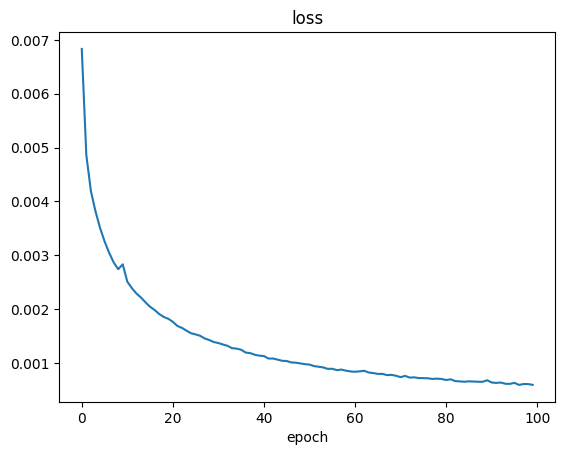

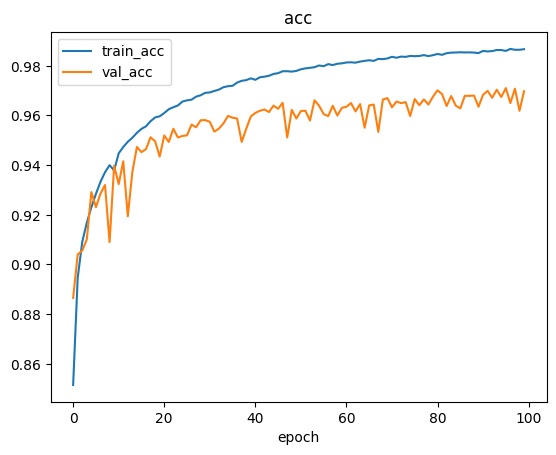

In [24]:
##display loss and acc
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
ax1.plot(np.arange(e+1),loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')


ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

In [25]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path, del_others = True):
    """get best model path by valuation list
    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir
    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    if del_others:
        for f in os.listdir(save_path):
            if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
                os.remove(os.path.join(save_path,f))
    return best_model_path

In [26]:
# save
PATH = 'E:/Roy/Sim Pool/Results/Training/3D2D1DConvKAN_Qingyun_30.pth'
torch.save(model.state_dict(), PATH)
# reload


best model:epoch_95_acc_0.9710.pth


  0%|          | 0/18700 [00:00<?, ?it/s]

inferring time: 211.46739411354065


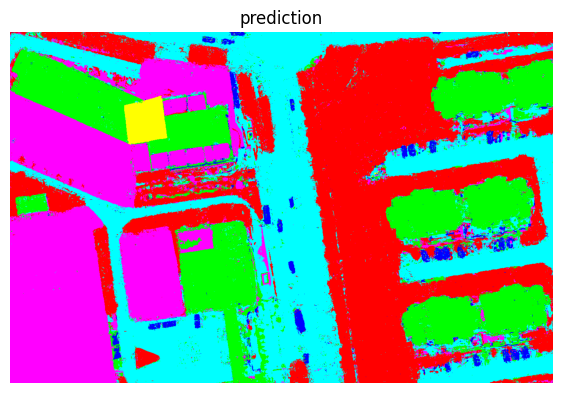

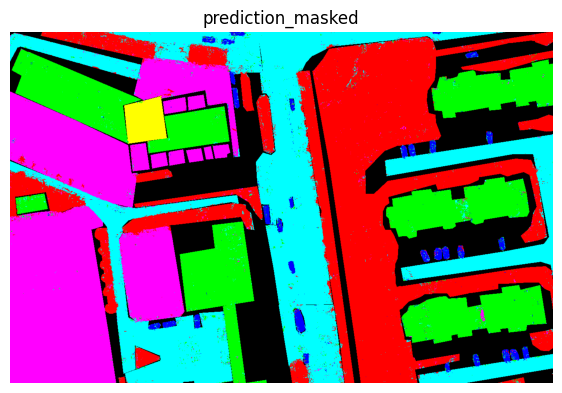

In [27]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH, not run_error)

best_model = model  ## modify to your model

best_model.load_state_dict(torch.load(best_model_path)['state_dict'])
## inference
best_model
best_model.eval()
pred_map = []
infer_st = time.time()

for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
infer_time = time.time() - infer_st


print(f"inferring time: {infer_time}")
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
img_display(classes=pred_map,title='prediction',figsize=(7,7))
img_display(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
# spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
# spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/3D2D1DConvKAN_prediction_Qingyun.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/3D2D1DConvKAN__prediction_masked_Qingyun.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [28]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'E:/Roy/Sim Pool/Results/Training/3D2D1DConvKAN_Qingyun_30_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9705831839278832
AA: 0.9490570949875338
Kappa: 0.9610675946361465
training time: 15074.515725374222
inferring time: 211.46739411354065
                    precision    recall  f1-score   support

             Trees     0.9713    0.9721    0.9717    139075
 Concrete building     0.9745    0.9788    0.9766     89757
               Car     0.8431    0.8100    0.8262      6891
 Ironhide building     0.9912    0.9902    0.9907      4884
Plastic playground     0.9799    0.9812    0.9805    108868
      Asphalt road     0.9649    0.9621    0.9635    127973

          accuracy                         0.9706    477448
         macro avg     0.9541    0.9491    0.9515    477448
      weighted avg     0.9705    0.9706    0.9705    477448

